## Recommeder Model

In [3]:
#Use conda to install scikit-surprise with the below command
#conda install -c conda-forge scikit-surprise

#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#surprise imports
import surprise
import json
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

## Load Data

In [4]:
#load in parquet data
raw_df = pd.read_parquet('../App_Data/input_runners_all.parquet')

#convert months to number
def mtn(x):
    months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    a = x.strip()[:3].lower()
    try:
        ez = months[a]
        return ez
    except:
        raise ValueError('Not a month')

raw_df["current_month"] =  raw_df["current_month"].apply(lambda x:mtn(x)) 

#create user ID
raw_df["user_id"] = raw_df["athlete"].astype(str) + "." + raw_df["current_month"].astype(str)

#remove any missings from the data
raw_df= raw_df[raw_df["prev_month_weekly_km"].notna()]

In [5]:
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency,user_id
0,0,47.48,6.185043,3.4,18 - 34,F,United States,10,4.0,0.225806,0.10
1,0,47.48,6.185043,3.4,18 - 34,F,United States,10,6.0,0.225806,0.10
2,0,47.48,6.185043,3.4,18 - 34,F,United States,10,8.0,0.225806,0.10
3,0,47.48,6.185043,3.4,18 - 34,F,United States,10,9.0,0.225806,0.10
4,0,47.48,6.185043,3.4,18 - 34,F,United States,10,10.0,0.225806,0.10


## Input New User Info

In [6]:
#filter dataset based on targets
gender = "F"
weekly_target = 40
age_bucket = "18 - 34"
month = mtn("October")
number_of_days = 5
new_id = '000.0'

#cold start for new user. Assumes long run 2x distance other runs.
new_user_data = { 
    'user_id' : [new_id] * 2,
    'run_distance_rounded' : [round(weekly_target/6), round(weekly_target/3)],
    'weekly_frequency' : [number_of_days -1, 1]
                }
new_user_df = pd.DataFrame(new_user_data)
new_user_df

,user_id,run_distance_rounded,weekly_frequency
0,000.0,7,4
1,000.0,13,1


## Train Model Based on User Filters

In [7]:
#define objects for Surprise. Must be in user, item, rating order
filtered_df = raw_df.loc[
    (raw_df['gender'] == gender) &
    (raw_df['age_bucket'] == age_bucket) &
    (raw_df['current_month'] == month) &
    (raw_df['prev_month_weekly_days_run'] > (number_of_days-1)) & 
    (raw_df['prev_month_weekly_days_run'] < (number_of_days+1)) &
    (raw_df['prev_month_weekly_km'] > weekly_target-5) &
    (raw_df['prev_month_weekly_km'] < weekly_target+5)
]

#append new user data

filtered_df = pd.concat([filtered_df,new_user_df])
    
data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

In [8]:
#train model with 3 fold cross validation
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5073  0.4139  0.3793  0.4335  0.0541  
MAE (testset)     0.3199  0.2954  0.2865  0.3006  0.0141  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.5073211 , 0.41391726, 0.37932791]),
 'test_mae': array([0.31992455, 0.29541089, 0.28649924]),
 'fit_time': (0.0019512176513671875,
  0.0018987655639648438,
  0.0018732547760009766),
 'test_time': (0.0011827945709228516,
  0.0009560585021972656,
  0.0009725093841552734)}

In [9]:
#fit the model using the full dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [10]:
#generate recommendations by generating a list of run distances based on the average expected run lenghy

def generate_run_ratings(user_id, weekly_target, number_of_days, long_run_multiple = 3):
    
    """
    Generates a list of run distances with ratings based on weekly target, 
    number of days run each week, with an optional param that sets the upper 
    bound long run distance
    """
    
    #create list of run lengths
    run_list = range(round(weekly_target/(number_of_days+(long_run_multiple-1))), round((weekly_target/number_of_days) * long_run_multiple))
    results_dict = {'run_distance': [],
                   'run_rating': []}
    
    
    for run in run_list:
        rating_prediction = svd.predict(uid = user_id, iid = run)[3]
        results_dict['run_distance'].append(run)
        results_dict['run_rating'].append(rating_prediction)
        
    return pd.DataFrame(results_dict)


predictions = generate_run_ratings(new_id, weekly_target, number_of_days)

In [11]:
#sorted recommendations
predictions.sort_values(by=['run_rating'], ascending = False)

,run_distance,run_rating
1,7,1.230321
4,10,1.045406
0,6,0.863161
2,8,0.854665
5,11,0.735029
7,13,0.721000
16,22,0.687002
8,14,0.684851
9,15,0.672302
3,9,0.667802


## Model Evaluation

In [12]:
import time
import seaborn as sns

In [13]:
#build function to run simulations

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= 50:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        '''    
        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        svd = SVD(verbose=False, n_epochs=10)
        validation = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
        '''
        
         #load in best hyperparameters
        with open('svdauto_tune_results.json') as json_file:
            parameters = json.load(json_file)
        parameters.pop('algo')
        parameters.pop('rmse')

        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model with cross validation
        algo = SVD(verbose=False, lr_bi = parameters['lr_bi'], lr_bu = parameters['lr_bu'], lr_pu = parameters['lr_pu'], lr_qi = parameters['lr_qi'], 
                   n_epochs = parameters['n_epochs'], n_factors = parameters['n_factors'], reg_bi= parameters['reg_bi'], reg_bu = parameters['reg_bu'], 
                   reg_pu = parameters['reg_pu'], reg_qi = parameters['reg_qi'])
        validation = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df5 = model_RMSE("F","55 +",10,100)
df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df6 = model_RMSE("M","55 +",10,100)

insufficient data for F 55 + 10
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 14
insufficient data for F 55 + 100
Finished in: 36.79216814041138
Finished in: 61.32130575180054
Finished in: 102.94264245033264
Finished in: 67.95676469802856
Finished in: 173.91421031951904
insufficient data for M 55 + 10
Finished in: 46.89768028259277


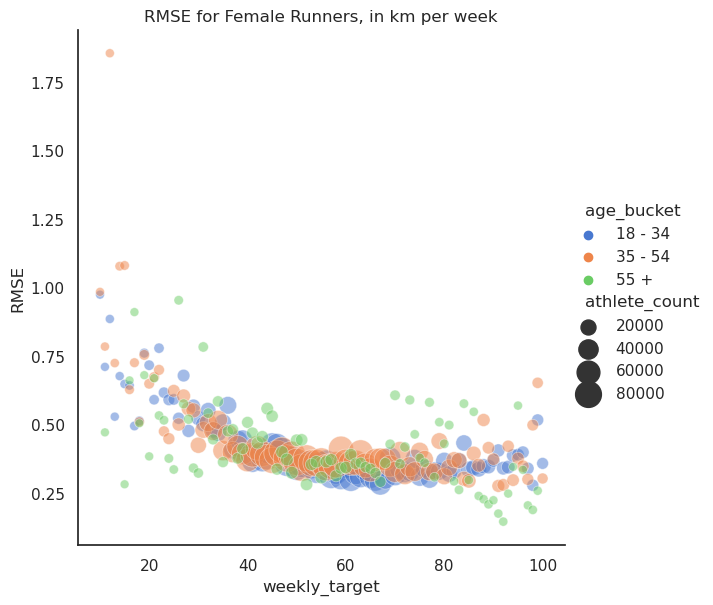

In [18]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "F"]
).set(title="RMSE for Female Runners, in km per week")

In [21]:
graph_df['RMSE'].mean()

0.48141582336738215

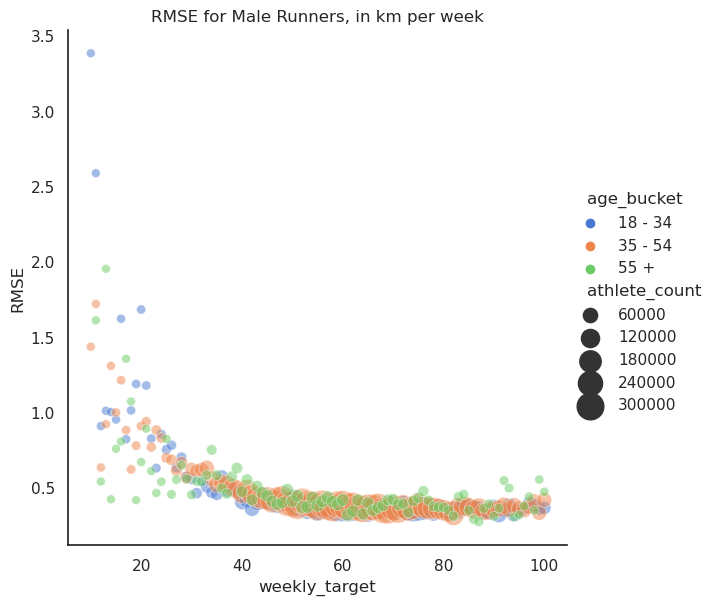

In [15]:
sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "M"]
).set(title="RMSE for Male Runners, in km per week")

In [ ]:
#EOF